Means for improvement: with more time, I would've liked to do some hypothesis tests, with more context, the statistical properties and identifying dependencies of asset returns. I understand a risk analyst, the responsibility is to manage exposure - with some hypothesis testing, it could provide backing to my ideas. 

Conducting tests like the Shapiro-Wilk or Kolmogorov-Smirnov would help me determine if asset returns follow a normal distribution. 

While doing research for this, the Granger Causality test is something I wanted to implement, to see if past returns of one asset can predict future returns of another, informing hedging and trading strategies.


It took me a while to get to grips with the data without much context, I was going to take a machine learning approach but without context it was quite hard. Applying some of the statistics I've learned while I have been at university was my approach. I had to read a paper on kurtosis and CVaR to understand this more. 

I also think machine learning would've uncovered some patterns I failed to recognise - but there was nothing I used here that was completely groundbreaking, only things I've learned during my course at university.

Here is the paper I read.

https://www.ise.ufl.edu/uryasev/files/2011/11/kro_CVaR.pdf

## Analysis of Asset Data

For now, we're going to proceed with loading and cleaning the data, then do some EDA and apply some stats methods

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
original_df = pd.read_csv('./data/assignment.csv', sep='|')

We're not going to make any changes to the df above, I'm going to use it to cross-check for any errors when data cleaning to see if the data is consistent and makes sense.

In [24]:
df = pd.read_csv('./data/assignment.csv', sep='|')
df.head()

,Date,Asset01,Asset02,Asset03,Asset04,Asset05,Asset06,Asset07,Asset08,Asset09,Asset10,Asset11
0,02-Jan-17,NaN,1012.35,NaN,NaN,NaN,NaN,2183.909,NaN,0.008456,41.880,NaN
1,03-Jan-17,225.24,1024.38,216.505,NaN,7500.0,86.91,2191.151,NaN,0.012008,42.500,29.038
2,04-Jan-17,226.58,1091.66,216.507,NaN,6730.0,87.38,2196.434,NaN,0.007042,42.370,29.005
3,05-Jan-17,226.40,971.26,216.510,NaN,6680.0,87.25,2178.558,NaN,-0.000195,42.625,29.153
4,06-Jan-17,227.21,898.16,216.518,NaN,6510.0,87.23,2183.933,NaN,-0.014470,41.875,29.478


In [25]:
df.isnull().sum()

Date          0
Asset01      59
Asset02      25
Asset03      69
Asset04      51
Asset05      60
Asset06      59
Asset07       3
Asset08    1609
Asset09       0
Asset10     652
Asset11      59
dtype: int64

### Cleaning

We're going to either drop the missing / nonsense values in the dataset so it doesn't skew the analysis later on.
Reformatting the dates to datetime format allows us to do some time-series analysis also.

In [26]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
df.set_index('Date', inplace=True)
df.head()

,Asset01,Asset02,Asset03,Asset04,Asset05,Asset06,Asset07,Asset08,Asset09,Asset10,Asset11
Date,,,,,,,,,,,
2017-01-02,NaN,1012.35,NaN,NaN,NaN,NaN,2183.909,NaN,0.008456,41.880,NaN
2017-01-03,225.24,1024.38,216.505,NaN,7500.0,86.91,2191.151,NaN,0.012008,42.500,29.038
2017-01-04,226.58,1091.66,216.507,NaN,6730.0,87.38,2196.434,NaN,0.007042,42.370,29.005
2017-01-05,226.40,971.26,216.510,NaN,6680.0,87.25,2178.558,NaN,-0.000195,42.625,29.153
2017-01-06,227.21,898.16,216.518,NaN,6510.0,87.23,2183.933,NaN,-0.014470,41.875,29.478


In [27]:
clean_df = df.dropna(how='all', subset=[f'Asset{i:02d}' for i in range(1, 12)])
filled_df = clean_df.fillna(method='ffill')
df = filled_df

We're going to forward fill the data, mainly to preserve integrity for both the data and the time series, which will help us calculate more accurate calculations. As this is for risk, we could be looking at volatility and value at risk.

### Exploratory data analysis

We're going to look for relationships, patterns and any possible trends in the data

In [28]:
df.describe()

,Asset01,Asset02,Asset03,Asset04,Asset05,Asset06,Asset07,Asset08,Asset09,Asset10,Asset11
count,1663.000000,1664.000000,1663.000000,1659.000000,1663.000000,1663.000000,1664.000000,1643.000000,1664.000000,1664.000000,1663.000
mean,332.232898,18008.960084,225.150670,50.573482,568.983851,84.103646,2374.717235,5693.143876,0.559407,60.455540,-inf
std,71.520276,16353.317057,7.474083,8.636053,1023.264708,4.672903,293.711079,236.029356,0.423893,61.488372,NaN
min,222.950000,789.110000,0.000000,37.747400,3.320000,68.630000,2042.333000,5316.745000,-0.070079,0.311000,-inf
25%,272.215000,6505.377500,220.404000,41.465400,20.905000,82.825000,2171.113000,5543.191000,0.237555,0.600000,44.559
50%,311.360000,10206.400000,228.129000,52.125600,243.200000,86.090000,2235.386000,5612.273000,0.346516,52.845000,74.390
75%,397.750000,27282.507500,228.524500,58.290700,564.100000,87.275000,2473.720500,5956.075000,0.981685,116.962500,142.285
max,477.710000,67734.040000,235.959000,66.085800,7500.000000,88.970000,3152.149000,6144.610000,1.453072,195.750000,182.010


Right off the bat, asset 11 has nonsense values, with the mean, max and standard deviation values making no sense, so it makes sense to look into why.

In [29]:
observed_11 = df[(df['Asset11'] == np.inf) | (df['Asset11'] == -np.inf) | (df['Asset11'].isnull())]
observed_11

,Asset01,Asset02,Asset03,Asset04,Asset05,Asset06,Asset07,Asset08,Asset09,Asset10,Asset11
Date,,,,,,,,,,,
2017-01-02,NaN,1012.35,NaN,NaN,NaN,NaN,2183.909,NaN,0.008456,41.88,NaN
2017-04-06,235.44,1199.17,216.75,40.22,3260.0,87.43,2178.900,5367.02,-0.004093,52.54,-inf


In [30]:
total_entries_11 = df['Asset11'].shape[0]
invalid_entries_11 = df['Asset11'].isin([np.inf, -np.inf]).sum() + df['Asset11'].isnull().sum()

invalid_percentage_11 = (invalid_entries_11 / total_entries_11) * 100

print(f"Total Entries: {total_entries_11}")
print(f"Invalid Entries: {invalid_entries_11}")
print(f"Percentage of Invalid Entries: {invalid_percentage_11:.2f}%")

Total Entries: 1664
Invalid Entries: 2
Percentage of Invalid Entries: 0.12%


Removing the rows with invalid entries on asset 11 won't have as big of an effect as I had thought, so they can be removed.

In [31]:
df_cleaned = df[~df['Asset11'].isin([np.inf, -np.inf])].copy()
df_cleaned = df_cleaned.dropna(subset=['Asset11'])

In [32]:
df = df_cleaned.copy()

In [33]:
df.describe()

,Asset01,Asset02,Asset03,Asset04,Asset05,Asset06,Asset07,Asset08,Asset09,Asset10,Asset11
count,1662.000000,1662.000000,1662.000000,1658.000000,1662.000000,1662.000000,1662.000000,1642.000000,1662.000000,1662.000000,1662.000000
mean,332.291137,18029.300878,225.155724,50.579726,567.364708,84.101645,2374.949862,5693.342490,0.560077,60.471479,91.976999
std,71.502347,16352.630821,7.473489,8.634911,1021.439504,4.673597,293.811185,235.963883,0.423706,61.523383,49.146940
min,222.950000,789.110000,0.000000,37.747400,3.320000,68.630000,2042.333000,5316.745000,-0.070079,0.311000,29.005000
25%,272.322500,6507.672500,220.413000,41.470050,20.892500,82.822500,2170.979000,5543.191000,0.237710,0.600000,44.563750
50%,311.410000,10220.005000,228.151000,52.125600,242.650000,86.090000,2235.699500,5612.273000,0.347014,53.085000,74.467500
75%,397.760000,27303.322500,228.524750,58.297250,563.150000,87.270000,2473.771500,5956.075000,0.982037,116.987500,142.347500
max,477.710000,67734.040000,235.959000,66.085800,7500.000000,88.970000,3152.149000,6144.610000,1.453072,195.750000,182.010000


### Plots

In [22]:
returns = df.pct_change().dropna()

#### Time Series

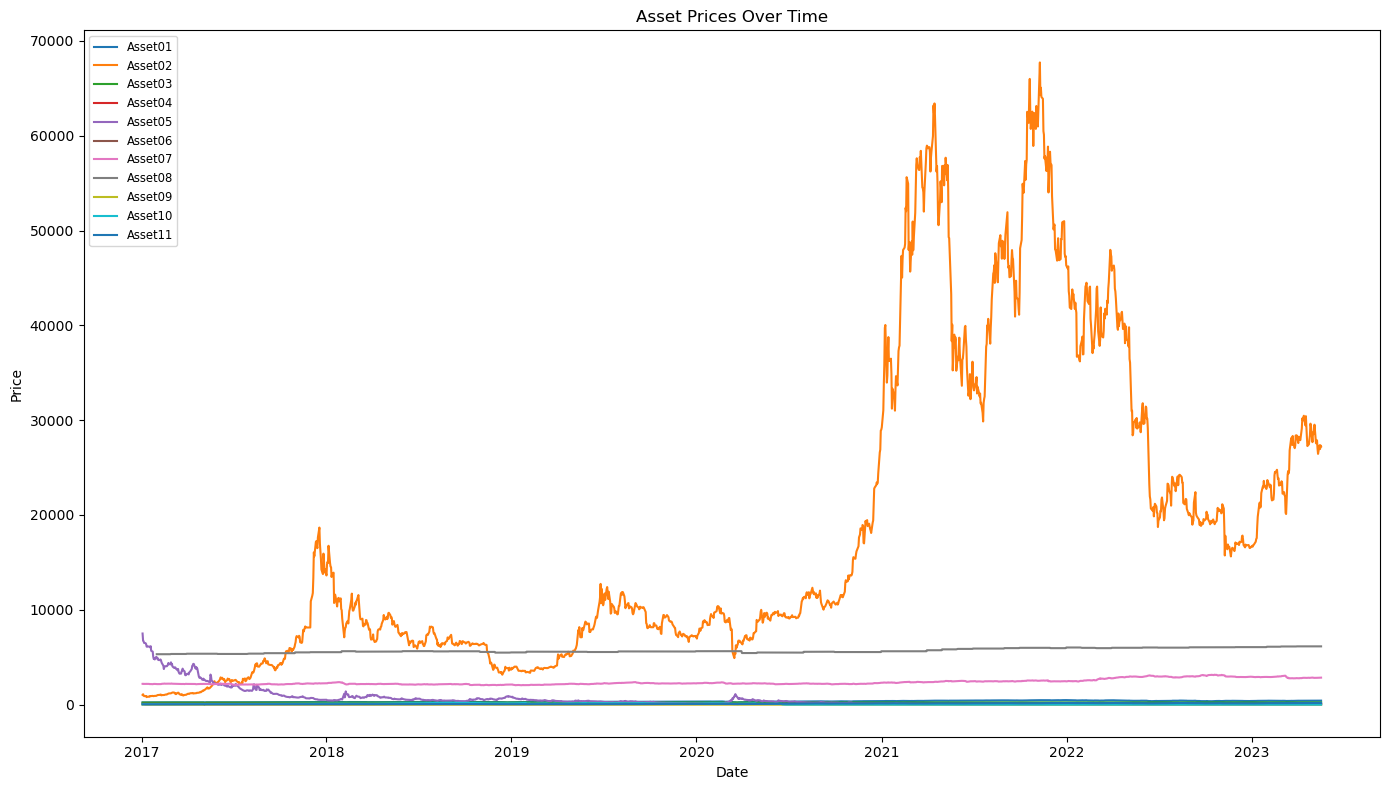

In [38]:
plt.figure(figsize=(14, 8))
for asset in df.columns:
    plt.plot(df.index, df[asset], label=asset)
plt.title('Asset Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

This plot only gives me information on how volatile asset 2 is.

I'm more interested in the relative changes over time, so I'm going to normalise assets such that they can start at the same value; we can then observe and compare performances of different assets a lot easier. 

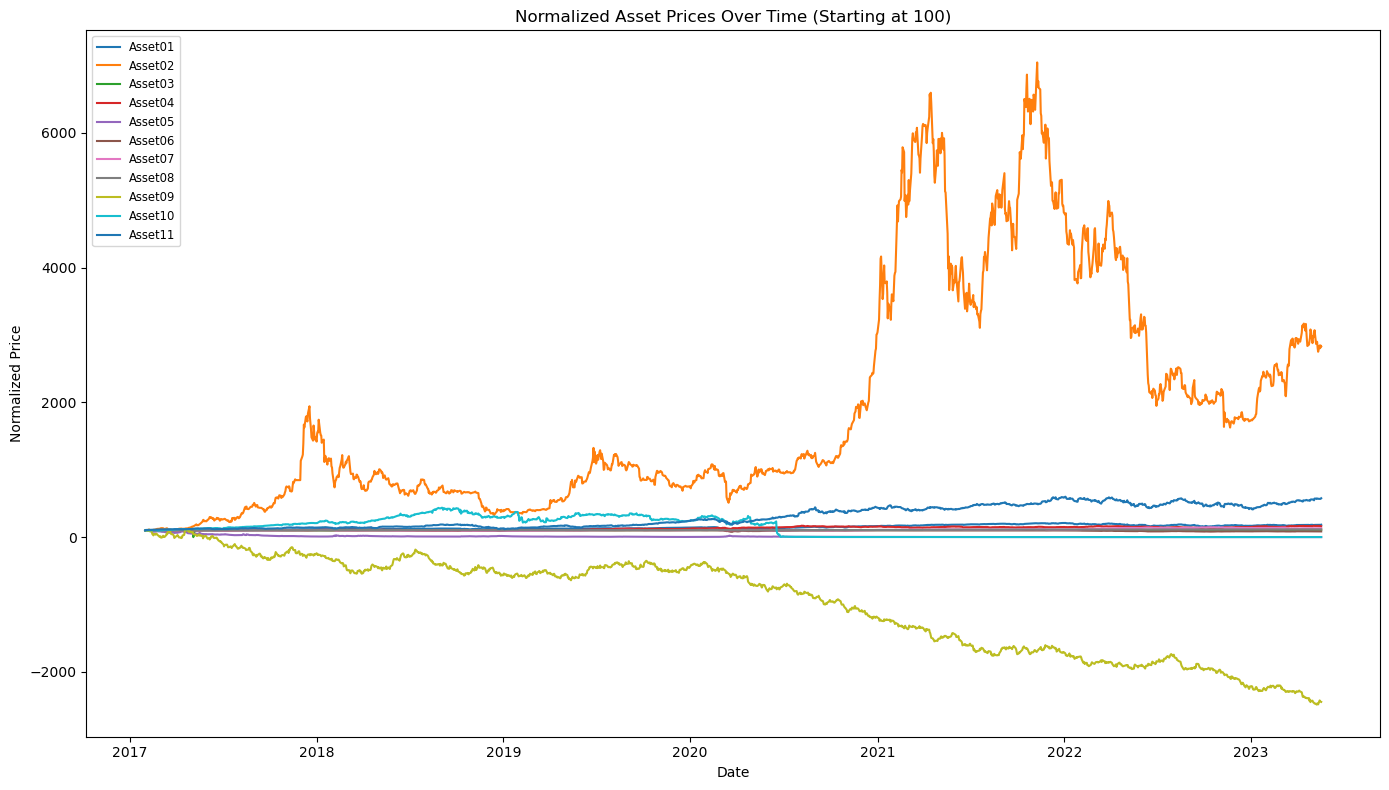

In [39]:
df_normalise = df.dropna().copy()
df_normalise = df_normalise / df_normalise.iloc[0] * 100

plt.figure(figsize=(14, 8))
for asset in df_normalise.columns:
    plt.plot(df_normalise.index, df_normalise[asset], label=asset)

plt.title('Normalized Asset Prices Over Time (Starting at 100)')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

We ended up getting more information from this in regards to the trend in asset 09's price, but probably not as much as we wanted - even after normalising, so let's plot the other assets on a different plot.

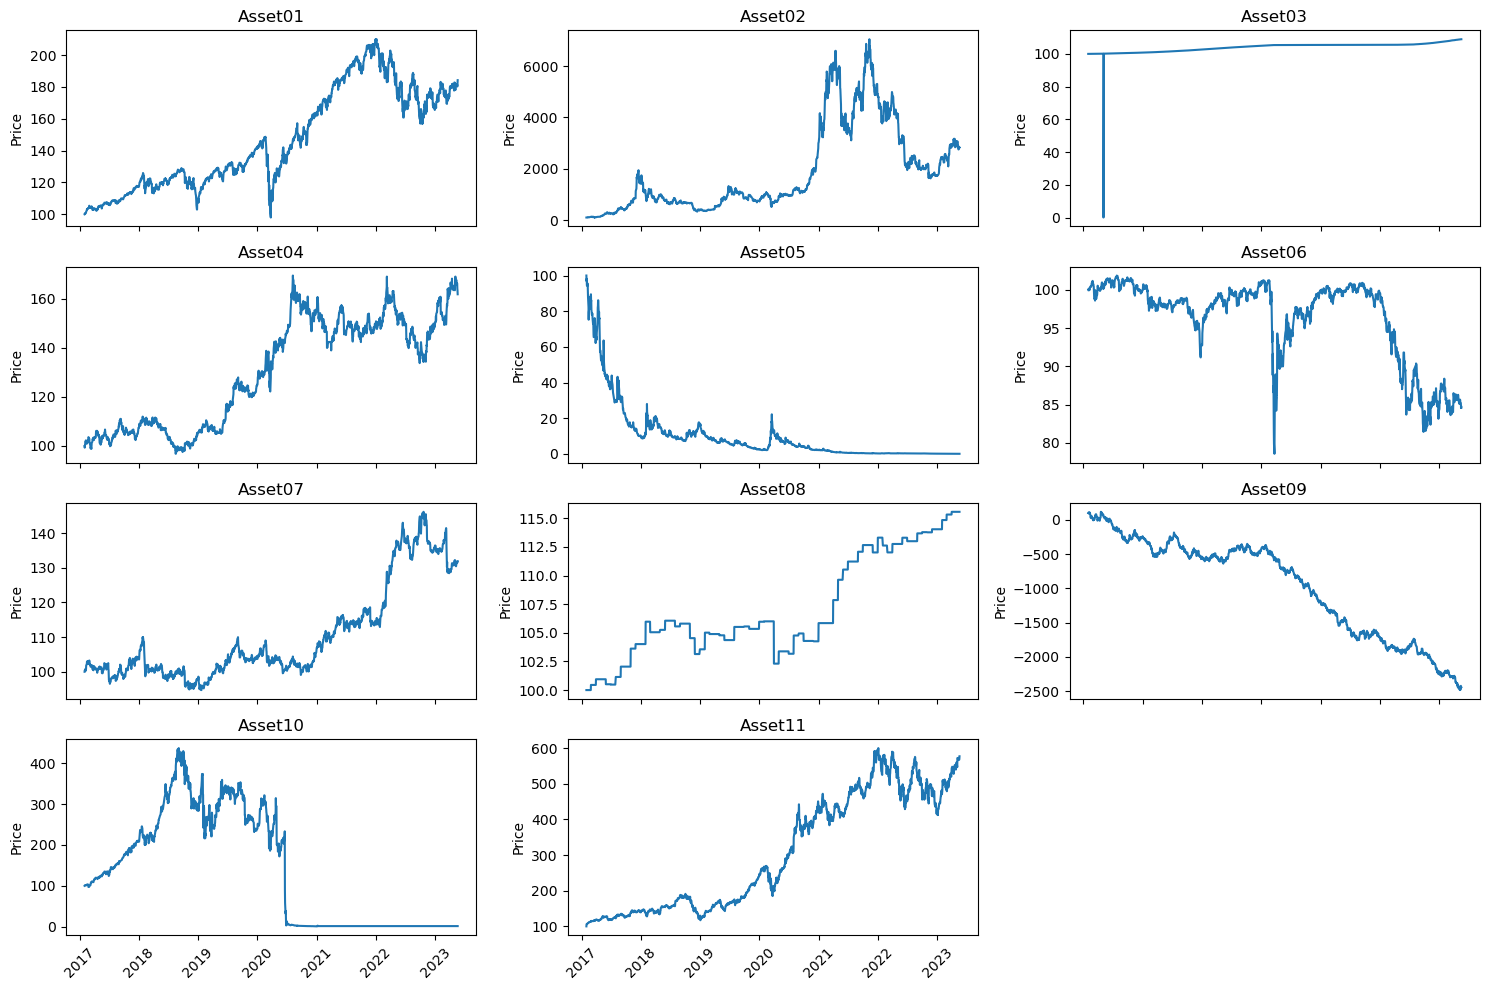

In [40]:
asset_columns = df_normalise.columns.tolist()
num_assets = len(asset_columns)

rows = 4
cols = 3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10), sharex=True)
axes = axes.flatten()


for i, asset in enumerate(asset_columns):
    axes[i].plot(df_normalise.index, df_normalise[asset])
    axes[i].set_title(asset)
    axes[i].set_ylabel('Price')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

This is so much more telling, since the pricing scales were different from each asset, we can see which assets are performing in what way.

There may be an error with asset 03 in the sense that either there's something wrong with the data quality or this is actually something that happened in the market - we will look into this. 

We also need to look into asset 09 and 05 to ensure what we're seeing is true.
I'm going to assume asset 10 is inactive.

Asset 01, 02, 07 and 11 show reliable growth so they have been performing well since the beginning of the data - keep note that despite the messy data we had for 11, it could be the best performing one, so we made a wise choose in cleaning the data the way we did.

Asset 04 is well performing in general with a lack of sharpe declines so it's steady

Asset 08 may lack trading liquidity because of the stair-like rise in price.

If I had more time, I would like to do a further analysis into asset 03 and asset 09 but I'm running out of time, so let's drop them.

## Calculating metrics

In [74]:
returns = df_normalise.pct_change().dropna()
returns.describe()


,Asset01,Asset02,Asset04,Asset05,Asset06,Asset07,Asset08,Asset11
count,1641.000000,1641.000000,1641.000000,1641.000000,1641.000000,1641.000000,1641.000000,1641.000000
mean,0.000448,0.003086,0.000330,-0.002038,-0.000084,0.000183,0.000090,0.001255
std,0.012260,0.045871,0.008598,0.072051,0.005919,0.005390,0.001701,0.019300
min,-0.109424,-0.271875,-0.053754,-0.334499,-0.054966,-0.045211,-0.034851,-0.128646
25%,-0.003743,-0.016524,-0.003828,-0.040335,-0.001907,-0.002343,0.000000,-0.007455
50%,0.000437,0.001578,0.000267,-0.010462,0.000000,0.000476,0.000000,0.000398
75%,0.005964,0.022321,0.004863,0.021632,0.001901,0.003311,0.000000,0.010839
max,0.090603,0.339921,0.052585,0.662064,0.065459,0.022740,0.019016,0.119807


In [64]:
mean_returns = returns.mean()
std_returns = returns.std()
skewness = returns.skew()
kurtosis = returns.kurtosis()

stats = pd.DataFrame({
    'Mean Return': mean_returns,
    'Volatility': std_returns,
    'Skewness': skewness,
    'Kurtosis': kurtosis
})

print(stats)

         Mean Return  Volatility  Skewness    Kurtosis
Asset01     0.000448    0.012260 -0.566085   12.665468
Asset02     0.003086    0.045871  0.304503    5.389028
Asset04     0.000330    0.008598 -0.298232    4.749281
Asset05    -0.002038    0.072051  2.135026   12.553395
Asset06    -0.000084    0.005919  0.125037   24.773766
Asset07     0.000183    0.005390 -1.181621    6.508471
Asset08     0.000090    0.001701 -1.150522  154.458416
Asset11     0.001255    0.019300 -0.006742    5.389977


Due to high value Kurtosis most notably 01, 05, 06, 08 are all incredibly likely to have extreme values.
We aren't as interested in the mean return as much as we are on the volatility and kurtosis.

5 is very volatile, with very high kurtosis, so keeping the inventory neutral for this asset is wise.

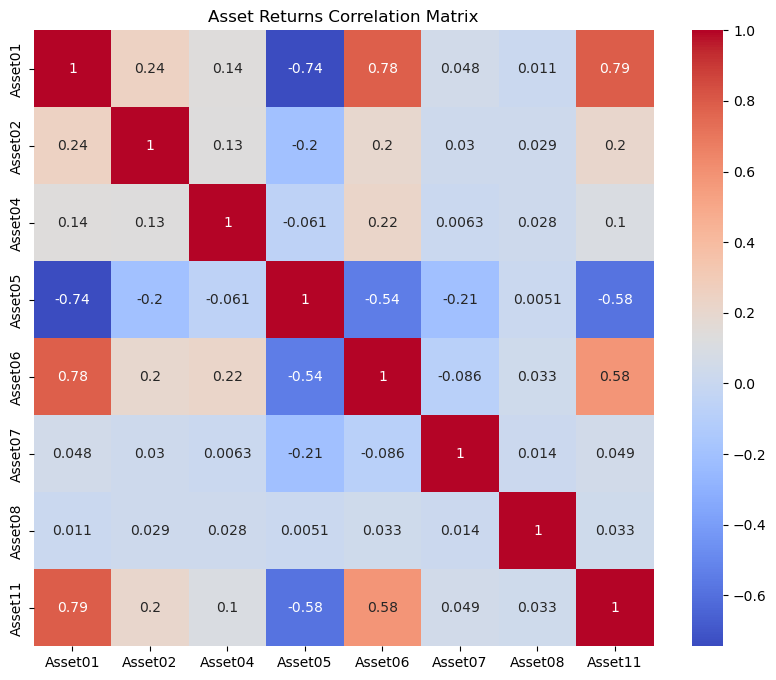

In [65]:
correlation_matrix = returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Asset Returns Correlation Matrix')
plt.show()

Asset01 and Asset06, Asset01 and Asset11 have strong positive correlations (>0.7). We can assume these prices will move together because of the data. From here, let's say there's a significant buy order for 01, you can adjust quotes for (6, 11) to account for expectation of movement. Vice versa for negatively correlated stocks like (1, 5)

Just from the correlation data alone, to keep it elementary, I suppose that having long positions in these 3 assets creates a risk of concentration and ideally we need to keep exposure balanced - so instead of holding long positions in all 3, short other less correlated assets to manage exposure.
You could also market-make the spread between asset (1, 6) to capitalise on the movement on the two. Providing liquidity, but also reducing directional risk


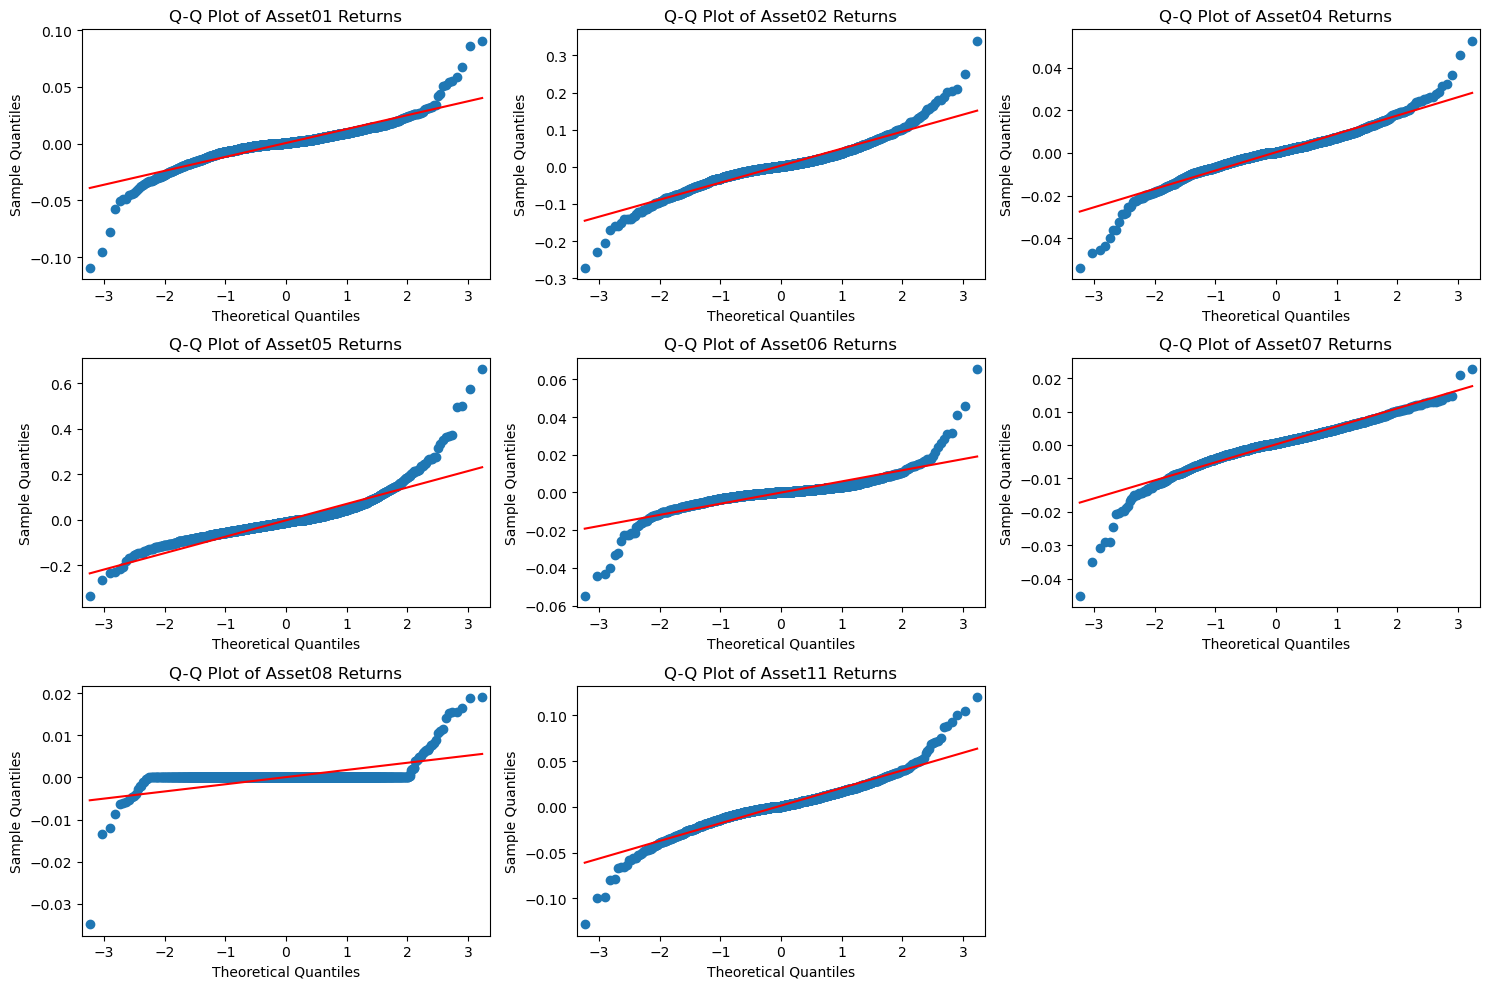

In [ ]:
import statsmodels.api as sm

assets = returns.columns
num_assets = len(assets)

rows = int(np.ceil(np.sqrt(num_assets)))
cols = int(np.ceil(num_assets / rows))


fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()


for i, asset in enumerate(assets):
    sm.qqplot(returns[asset], line='s', ax=axes[i])
    axes[i].set_title(f'Q-Q Plot of {asset} Returns')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



The plots confirm a lack of normality, and greater outlier risks with fat tails across most assets - so we need to take a look at employing dynamic spreads and managing our exposure at any given moment since all the assets are prone to market shocks. Keep the spreads wider at times of extreme movements because of the fat tails. 

We knew from before, because of the high kurtosis values to minimise inventory for (5, 8) as if not properly hedged then we could experience high losses.